<a href="https://colab.research.google.com/github/romjiik/Course_work/blob/main/BERT_%20CNN_and_GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Download libraries

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
!pip3 install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 47.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.1
    Uninstalling transformers-4.30.1:
      Successfully uninstalled transformers-4.30.1


In [2]:
!pip install wandb -qU

In [3]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 4.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 8.4 MB/s eta 0:00:00


In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
from torcheval.metrics.functional import multiclass_f1_score

import wandb

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Download and prepare data

In [7]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = True

In [8]:
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 9000 # Time in seconds for automl run
TARGET_NAME = 'rating_value' # Target column name

In [9]:
df = pd.read_csv('/kaggle/input/bank-reviews-dataset/final_review_dataset_extended.csv')
df['rating_value'] = df['rating_value'] - 1

In [10]:
train_data, test_data = train_test_split(df,
                                         test_size=TEST_SIZE,
                                         stratify=df[TARGET_NAME],
                                         random_state=10)

print('Data splitted. Parts sizes: train_data = {}, test_data = {}'
              .format(train_data.shape, test_data.shape))

Data splitted. Parts sizes: train_data = (9913, 16), test_data = (2479, 16)


In [11]:
train, valid = train_test_split(train_data,
                                         test_size=TEST_SIZE,
                                         stratify=train_data[TARGET_NAME],
                                         random_state=10)

print('Data splitted. Parts sizes: train = {}, valid = {}'
              .format(train.shape, valid.shape))

Data splitted. Parts sizes: train = (7930, 16), valid = (1983, 16)


## Create dataset

In [12]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):

    def __init__(self, texts, targets, tokenizer, max_len=512):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        target = self.targets[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
          'text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

## Models architecture
### BERT

In [13]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, BertModel

class BertClassifier(nn.Module):

    def __init__(self, model_path, tokenizer_path, n_classes=5, max_len=512):
        super(BertClassifier, self).__init__()

        self.bert_model = BertModel.from_pretrained(model_path)
        self.out_features = self.bert_model.config.hidden_size
        self.max_len = max_len
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
        # изначально берт ретернит аутпут вида [batch size, len tokens in text, hidden size модели] в моем случае это [16, 512, 312/768]
        # после permute(0,2,1) будет [16,312,512]
        self.conv = nn.Conv1d(in_channels=self.out_features, out_channels=int(self.out_features / 3), kernel_size=5, padding=0, stride=1)
        #formula l_out = [(l_in + 2 * padding - 1 * (kernel_size - 1) - 1) / stride + 1]
        self.conv_l_out = np.floor((self.max_len + 2 * 0 - 1 * (5 - 1) - 1) / 1 + 1)
        # [16,104,508]
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=5, stride=2)
        self.pool_l_out = np.floor((self.conv_l_out + 2 * 0 - 1 * (5 - 1) - 1) / 2 + 1)
        # [16, 104, 250]
        self.dropout = nn.Dropout(0.3)
        self.clf = nn.Linear(self.conv.out_channels * int(self.pool_l_out), n_classes)

    def forward(self, input_ids, attention_mask):
        x = self.bert_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(x)
        x = self.clf(x)
        return x


### GPT

In [14]:
import torch
import torch.nn as nn
from transformers import GPT2Model, GPT2Tokenizer, GPT2Config, GPT2ForSequenceClassification


class GPTClassifier(nn.Module):
    def __init__(self, model_path, tokenizer_path, n_classes=5, max_len=512):
        super(GPTClassifier, self).__init__()
        self.max_len = max_len
        self.gpt_config = GPT2Config.from_pretrained(model_path, num_labels=n_classes)
        self.gpt_model = GPT2Model.from_pretrained(model_path, config=self.gpt_config)
        self.tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_path)
        self.tokenizer.padding_side = "left"
        if self.tokenizer.pad_token is None:
            self.tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        self.gpt_model.resize_token_embeddings(len(self.tokenizer))
        self.clf = nn.Linear(self.gpt_config.hidden_size, n_classes)


    def forward(self, input_ids, attention_mask):
        outputs = self.gpt_model(input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state
        pooled_output = hidden_state[:, 0]
        logits = self.clf(pooled_output)
        return logits


## Trainer

In [15]:
class Trainer:
    def __init__(self, model, epochs=1, batch_size=16, model_save_path='/content/bert.pt'):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.tokenizer = self.model.tokenizer
        self.max_len = self.model.max_len
        self.epochs = epochs
        self.batch_size = batch_size
        self.model_save_path = model_save_path

    def preparation(self, X_train, y_train, X_valid, y_valid):
        data = pd.concat([pd.Series(X_train), pd.Series(y_train)], axis=1, ignore_index=True).rename(columns={0: 'review', 1: 'rating_value'})
        # create datasets
        self.train_set = CustomDataset(X_train, y_train, self.tokenizer)
        self.valid_set = CustomDataset(X_valid, y_valid, self.tokenizer)

        # create data loaders
        self.train_loader = DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True)
        self.valid_loader = DataLoader(self.valid_set, batch_size=self.batch_size, shuffle=True)

        # helpers initialization
        self.optimizer = AdamW(self.model.parameters(), lr=2e-5, correct_bias=False)
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=0,
                num_training_steps=len(self.train_loader) * self.epochs
            )
#         # c учетом дисбаланса
#         weights = torch.tensor(list(data.groupby('rating_value').count().review.max() / data.groupby('rating_value').count().review))
#         self.loss_fn = torch.nn.CrossEntropyLoss(weight=weights).to(self.device)
        # без учета дисбаланса
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)

    def fit(self):
        self.model = self.model.train()
        losses = []
        f1_micro_scores = []
        f1_macro_scores = []
        accuracy_scores = []
        correct_predictions = 0

        for step, data in enumerate(tqdm(self.train_loader)):
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)
            # print(input_ids.shape, targets.shape)
            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )
            preds = torch.argmax(outputs, dim=1)

            loss = self.loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            acc = torch.sum(preds == targets) / len(targets)
            f1_micro = multiclass_f1_score(preds, targets, num_classes=5, average='micro')
            f1_macro = multiclass_f1_score(preds, targets, num_classes=5, average='macro')

            losses.append(loss.item())
            f1_micro_scores.append(f1_micro)
            f1_macro_scores.append(f1_macro)
            accuracy_scores.append(acc)

            if step % 10 == 0:
              wandb.log({
                  'loss': torch.mean(torch.tensor(losses[-10:], dtype=torch.float32)),
                  'accuracy': torch.mean(torch.tensor(accuracy_scores[-10:], dtype=torch.float32)),
                  'f1_micro': torch.mean(torch.tensor(f1_micro_scores[-10:], dtype=torch.float32)),
                  'f1_macro': torch.mean(torch.tensor(f1_macro_scores[-10:], dtype=torch.float32))
                  })

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()


        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = torch.mean(torch.tensor(losses, dtype=torch.float32))
        return train_acc, train_loss

    def eval(self):
        self.model = self.model.eval()
        losses = []
        correct_predictions = 0

        with torch.no_grad():
            for data in tqdm(self.valid_loader):
                input_ids = data["input_ids"].to(self.device)
                attention_mask = data["attention_mask"].to(self.device)
                targets = data["targets"].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                    )

                preds = torch.argmax(outputs, dim=1)
                loss = self.loss_fn(outputs, targets)
                correct_predictions += torch.sum(preds == targets)
                losses.append(loss.item())

        val_acc = correct_predictions.double() / len(self.valid_set)
        val_loss = np.mean(losses)
        return val_acc, val_loss

    def train(self):
        best_accuracy = 0
        for epoch in tqdm(range(self.epochs)):
            # print(f'Epoch {epoch + 1}/{self.epochs}')
            train_acc, train_loss = self.fit()
            wandb.log({'train_acc': train_acc})
            # print(f'Train loss {train_loss} accuracy {train_acc}')

            val_acc, val_loss = self.eval()
            wandb.log({'val_acc': val_acc})
            # print(f'Val loss {val_loss} accuracy {val_acc}')
            # print('-' * 10)

            if val_acc > best_accuracy:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'loss': val_loss,
                    'accuracy': val_acc,
                    }, self.model_save_path)
                best_accuracy = val_acc

        state = torch.load(self.model_save_path)
        self.model.load_state_dict(state['model_state_dict'])
        data = pd.DataFrame(config, index=[0])
        data['accuracy'], data['loss'] =  state['accuracy'], state['loss']
        table = wandb.Table(data=data)
        wandb.log({'config': table})

        wandb.finish()

    def predict(self, text):
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }

        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)

        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        prediction = outputs.cpu().detach()

        return prediction


# Training BERT

## Logging

In [16]:
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [17]:
config={
      "learning_rate": 2e-5,
      "architecture": "cointegrated/rubert-tiny-sentiment-balanced + CNN",
      "weight_balance": False,
      "dataset": "Bank_review_dataset",
      "epochs": 3,
      "batch_size": 16,
}

wandb.init(
    # Set the project where this run will be logged
    project="course_work",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"tiny_bert + CNN",
    # Track hyperparameters and run metadata
    config=config)

wandb: Currently logged in as: berdyshevrv (romjiik). Use `wandb login --relogin` to force relogin


In [18]:
# cointegrated/LaBSE-en-ru
# cointegrated/rubert-tiny-sentiment-balanced
# DeepPavlov/rubert-base-cased-conversational

seed_everything(42)

classifier = BertClassifier(
        model_path='cointegrated/rubert-tiny-sentiment-balanced',
        tokenizer_path='cointegrated/rubert-tiny-sentiment-balanced'
)

trainer = Trainer(
        model=classifier,
        epochs=config['epochs'],
        batch_size=config['batch_size'],
#         model_save_path='/content/drive/MyDrive/Colab Notebooks/course_work/models/test.pt'
        model_save_path = '/kaggle/working/deeppavlov_bert_CNN_e3_b16_weighted.pt'
)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
trainer.preparation(
        X_train=list(train['review']),
        y_train=list(train['rating_value']),
        X_valid=list(valid['review']),
        y_valid=list(valid['rating_value'])
    )

In [20]:
%%time
trainer.train()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

accuracy,▂▄▆▇█▆▄▆▄▇▇▁▆▅█▆▇▆▆▇▅▄█▇▇▅▆▇▆█▅▆▆▆▇▇▇█▆▆
f1_macro,▁▁▄▆▆▄▄▆▃▆▄▂▅▄▇▆▆▄▅▆▅▄▇▅▅▄▄▆▅▇▄▆▅▅▇███▆▆
f1_micro,▂▄▆▇█▆▄▆▄▇▇▁▆▅█▆▇▆▆▇▅▄█▇▇▅▆▇▆█▅▆▆▆▇▇▇█▆▆
loss,█▆▄▃▄▄▄▄▄▄▅▃▄▄▂▂▄▄▄▂▃▃▂▅▃▃▄▃▃▃▁▃▂▃▂▂▁▂▃▂
train_acc,▁▇█
val_acc,█▁▂
accuracy,0.7
f1_macro,0.51618
f1_micro,0.7
loss,0.84001
train_acc,0.73228


CPU times: user 44min 49s, sys: 25.5 s, total: 45min 15s
Wall time: 45min 32s


In [35]:
texts = list(valid['review'])
predictions = [trainer.predict(t) for t in texts]

In [36]:
labels_true = valid['rating_value']
labels_pred = torch.argmax(nn.functional.softmax(torch.cat(predictions,dim=0), dim=1), dim=1)

In [37]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

precision, recall, f1score = precision_recall_fscore_support(labels_true, labels_pred,average='micro')[:3]

print(f'MICRO AVERAGE: precision: {precision}, recall: {recall}, f1score: {f1score}')

precision, recall, f1score = precision_recall_fscore_support(labels_true, labels_pred,average='macro')[:3]

print(f'MACRO AVERAGE: precision: {precision}, recall: {recall}, f1score: {f1score}')


MICRO AVERAGE: precision: 0.827029752899647, recall: 0.827029752899647, f1score: 0.827029752899647
MACRO AVERAGE: precision: 0.3492697288117603, recall: 0.38680526909220914, f1score: 0.3622027432029736


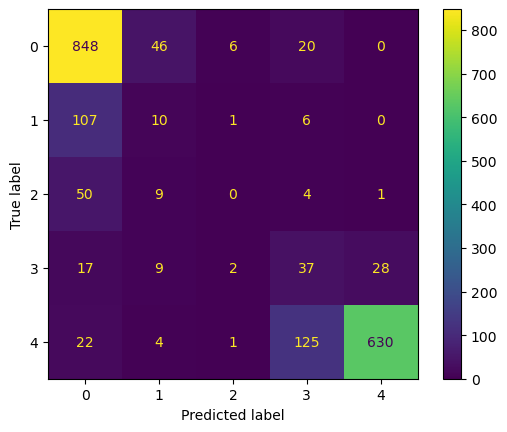

In [24]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels_true, labels_pred, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1,2,3,4])
disp.plot()
plt.show()


# Training GPT

## Logging

In [26]:
import wandb
wandb.login()

# ai-forever/rugpt3small_based_on_gpt2
config={
      "learning_rate": 2e-5,
      "architecture": "ai-forever/rugpt3small_based_on_gpt2",
      "weight_balance": False,
      "dataset": "Bank_review_dataset",
      "epochs": 3,
      "batch_size": 8,
}

wandb.init(
    # Set the project where this run will be logged
    project="course_work",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"GPT3",
    # Track hyperparameters and run metadata
    config=config)

In [27]:
seed_everything(42)

classifier = GPTClassifier(
        model_path='ai-forever/rugpt3small_based_on_gpt2',
        tokenizer_path='ai-forever/rugpt3small_based_on_gpt2'
)

trainer = Trainer(
        model=classifier,
        epochs=config['epochs'],
        batch_size=config['batch_size'],
#         model_save_path='/content/drive/MyDrive/Colab Notebooks/course_work/models/gpt3_e1_b16.pt'
        model_save_path = '/kaggle/working/gpt3_e3_b8_weighted.pt'
)

Some weights of the model checkpoint at ai-forever/rugpt3small_based_on_gpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using pad_token, but it is not set yet.


In [28]:
trainer.preparation(
        X_train=list(train['review']),
        y_train=list(train['rating_value']),
        X_valid=list(valid['review']),
        y_valid=list(valid['rating_value'])
    )

In [29]:
%%time
trainer.train()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

accuracy,▁▃▄▆▇▄▇▆▆▆▆▆▇▂▅▆▆▅▇█▆▆█▇▇▇▇█▇▆▇▇▇▇▇▇▇▇██
f1_macro,▁▃▄▆▆▄▇▆▆▆▄▆▆▂▅▆▅▄██▆▅█▇▇▆▇█▆▆▇▆▆▇▇▇▆▆██
f1_micro,▁▃▄▆▇▄▇▆▆▆▆▆▇▂▅▆▆▅▇█▆▆█▇▇▇▇█▇▆▇▇▇▇▇▇▇▇██
loss,█▆▄▅▅▆▄▃▆▃▄▄▃▅▃▃▃▄▂▃▃▃▂▆▃▃▂▂▂▃▃▂▂▂▁▂▂▃▂▂
train_acc,▁▆█
val_acc,▁█▇
accuracy,0.875
f1_macro,0.7027
f1_micro,0.875
loss,0.8643
train_acc,0.81929


CPU times: user 46min 30s, sys: 14.8 s, total: 46min 45s
Wall time: 47min 1s


In [30]:
texts = list(valid['review'])
predictions = [trainer.predict(t) for t in texts]

In [31]:
labels_true = valid['rating_value']
labels_pred = torch.argmax(nn.functional.softmax(torch.cat(predictions,dim=0), dim=1), dim=1)

In [32]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

precision, recall, f1score = precision_recall_fscore_support(labels_true, labels_pred,average='micro')[:3]

print(f'MICRO AVERAGE: precision: {precision}, recall: {recall}, f1score: {f1score}')

precision, recall, f1score = precision_recall_fscore_support(labels_true, labels_pred,average='macro')[:3]

print(f'MACRO AVERAGE: precision: {precision}, recall: {recall}, f1score: {f1score}')


MICRO AVERAGE: precision: 0.827029752899647, recall: 0.827029752899647, f1score: 0.827029752899647
MACRO AVERAGE: precision: 0.3492697288117603, recall: 0.38680526909220914, f1score: 0.3622027432029736


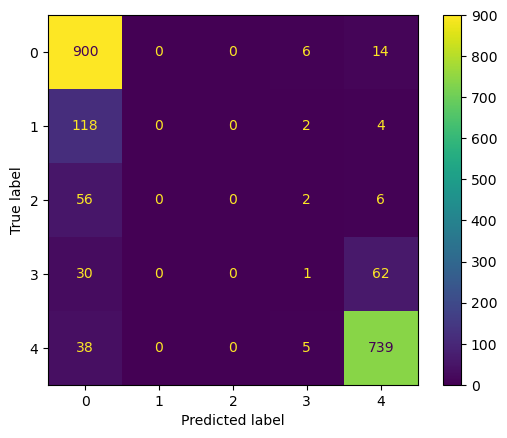

In [33]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels_true, labels_pred, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1,2,3,4])
disp.plot()
plt.show()
